In [15]:
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import pandas as pd
import scanpy
import argparse
import random
#import magic
import pickle
#import umap
#import bbknn
#import scvi
from sklearn.decomposition import PCA

#from dance.modules.multi_modality.predict_modality import BabelWrapper


# TORCH model
import torch.nn as nn
from torch import Tensor
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [2]:
X_train = ad.read_h5ad('/mnt/scratch/grunew14/data/Gex_processed_training.h5ad')
X_test = ad.read_h5ad('/mnt/scratch/grunew14/data/Gex_processed_testing.h5ad')
y_train = ad.read_h5ad("/mnt/scratch/grunew14/data/Adt_processed_training.h5ad")
y_test = ad.read_h5ad('/mnt/scratch/grunew14/data/Adt_processed_testing.h5ad')

## bbknn

In [3]:
bbknn.bbknn(X_train)


In [4]:
scanpy.tl.leiden(X_train)

In [5]:
X_train.X = X_train.X.toarray()

In [6]:
bbknn.ridge_regression(X_train, batch_key=['batch'], confounder_key=['leiden'])

In [7]:
scanpy.tl.pca(X_train)

In [8]:
bbknn.bbknn(X_train)

/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


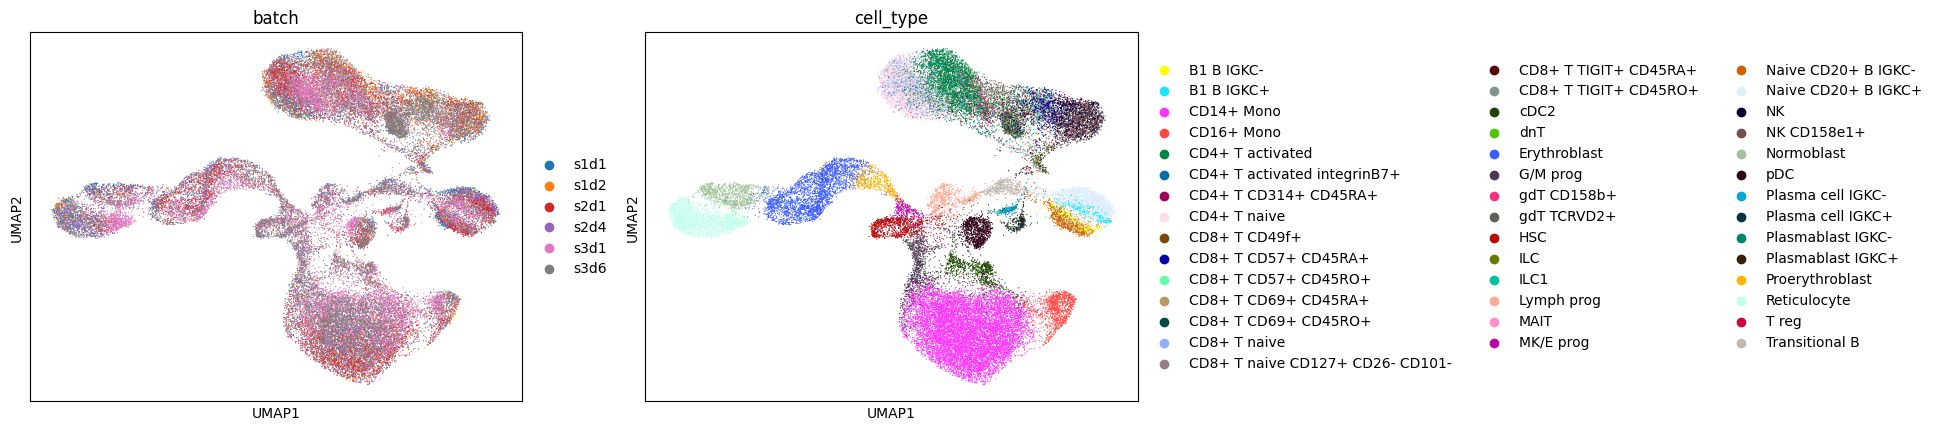

In [20]:
scanpy.tl.umap(X_train)
scanpy.pl.umap(X_train, color=['batch','cell_type'])

In [9]:
X_test.X = X_test.X.toarray()

In [10]:
bbknn.bbknn(X_test)

scanpy.tl.leiden(X_test)

/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


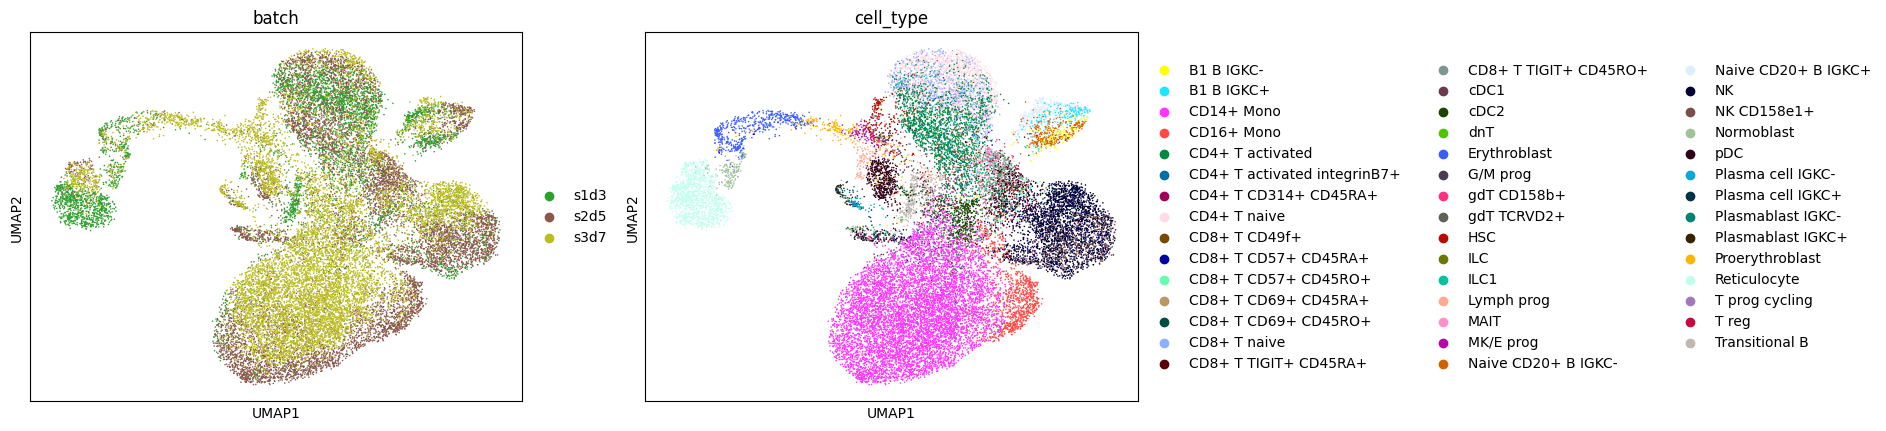

In [11]:
bbknn.ridge_regression(X_test, batch_key=['batch'], confounder_key=['leiden'])
scanpy.pp.pca(X_test)
bbknn.bbknn(X_test, batch_key='batch')
scanpy.tl.umap(X_test)
scanpy.pl.umap(X_test, color=['batch','cell_type'])

## scVI

In [68]:
X_train = ad.read_h5ad('/mnt/scratch/grunew14/data/Gex_processed_training.h5ad')
X_test = ad.read_h5ad('/mnt/scratch/grunew14/data/Gex_processed_testing.h5ad')
y_train = ad.read_h5ad("/mnt/scratch/grunew14/data/Adt_processed_training.h5ad")
y_test = ad.read_h5ad('/mnt/scratch/grunew14/data/Adt_processed_testing.h5ad')

In [4]:
scvi.settings.verbosity = 2
scvi.model.SCVI.setup_anndata(X_train, batch_key='batch', layer='counts')
model = scvi.model.SCVI(X_train, n_layers=2, n_latent=30, gene_likelihood="nb")

In [5]:
model.train()

/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/grunew14/anaconda3/envs/dance-env/lib/pyth ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mnt/home/grunew14/anaconda3/envs/dance-env/lib/pyth ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 190/190: 100%|██████████| 190/190 [1:42:55<00:00, 32.62s/it, loss=3.86e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=190` reached.


Epoch 190/190: 100%|██████████| 190/190 [1:42:55<00:00, 32.50s/it, loss=3.86e+03, v_num=1]


In [5]:
scvi.__version__

'0.20.3'

In [6]:
model.save('scvi_models/')

In [3]:
scvi_loaded = scvi.model.SCVI.load('scvi_models/', adata=X_train, use_gpu=True)

INFO     File scvi_models/model.pt already downloaded                                                              


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/scvi/data/_utils.py:119: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [10]:
scvi_loaded.adata_manager.transfer_fields(X_test, extend_categories=True)
latent_representation_test = scvi_loaded.get_latent_representation(X_test)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


ValueError: Category s1d3 not found in source registry. Cannot transfer setup without `extend_categories = True`.

In [60]:
X_train.obsm["X_scVI"] = scvi_loaded.get_latent_representation()
X_train.layers["scvi_normalized"] = scvi_loaded.get_normalized_expression(library_size=10e4)

In [61]:
scvi_loaded.get_anndata_manager.

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/scvi/data/_utils.py:119: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


ValueError: Category s1d3 not found in source registry. Cannot transfer setup without `extend_categories = True`.

In [9]:
scanpy.tl.pca(X_train)
scanpy.pp.neighbors(X_train, n_pcs=30, n_neighbors=20)
scanpy.tl.umap(X_train, min_dist=0.3)

/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


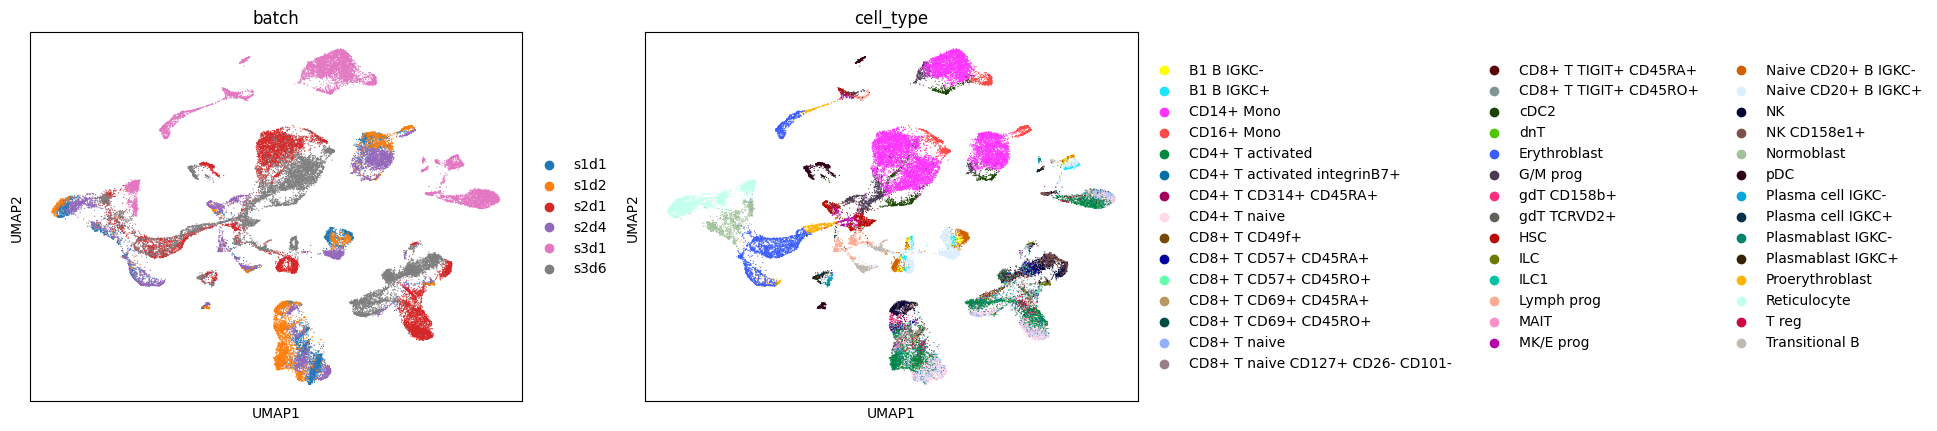

In [11]:
scanpy.pl.umap(X_train, color=['batch','cell_type'])

In [12]:
h5adscanpy.pp.neighbors(X_train, use_rep="X_scVI")
scanpy.tl.umap(X_train, min_dist=0.3)

/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


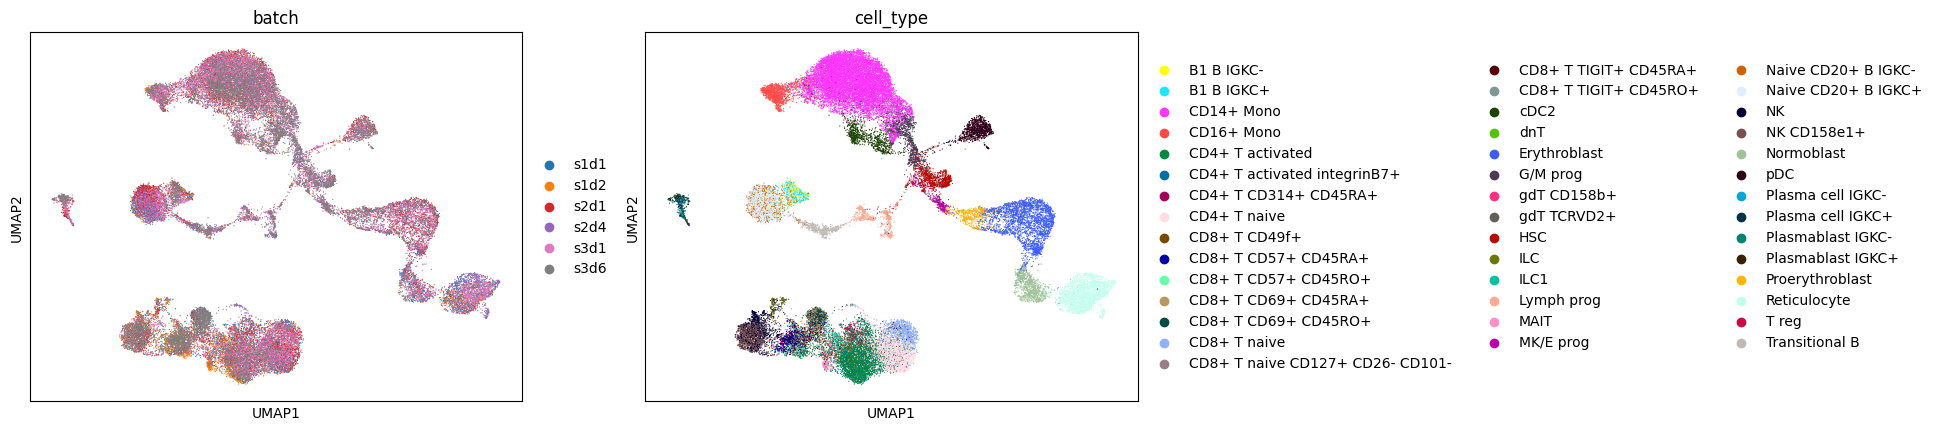

In [13]:
scanpy.pl.umap(X_train, color=['batch','cell_type'])

In [ ]:
markers = {}
cats  = X_train.obs.cell_type.cat.categories

In [19]:
X_train.var

gene_ids feature_types  genome  n_cells
AL627309.5  ENSG00000241860           GEX  GRCh38     69.0
LINC01409   ENSG00000237491           GEX  GRCh38    303.0
LINC01128   ENSG00000228794           GEX  GRCh38    703.0
LINC00115   ENSG00000225880           GEX  GRCh38    103.0
FAM41C      ENSG00000230368           GEX  GRCh38    130.0
...                     ...           ...     ...      ...
MT-CYB      ENSG00000198727           GEX  GRCh38   6136.0
AC011043.1  ENSG00000276256           GEX  GRCh38     51.0
AL592183.1  ENSG00000273748           GEX  GRCh38    482.0
AC240274.1  ENSG00000271254           GEX  GRCh38     53.0
AC007325.4  ENSG00000278817           GEX  GRCh38     41.0

[13953 rows x 4 columns]

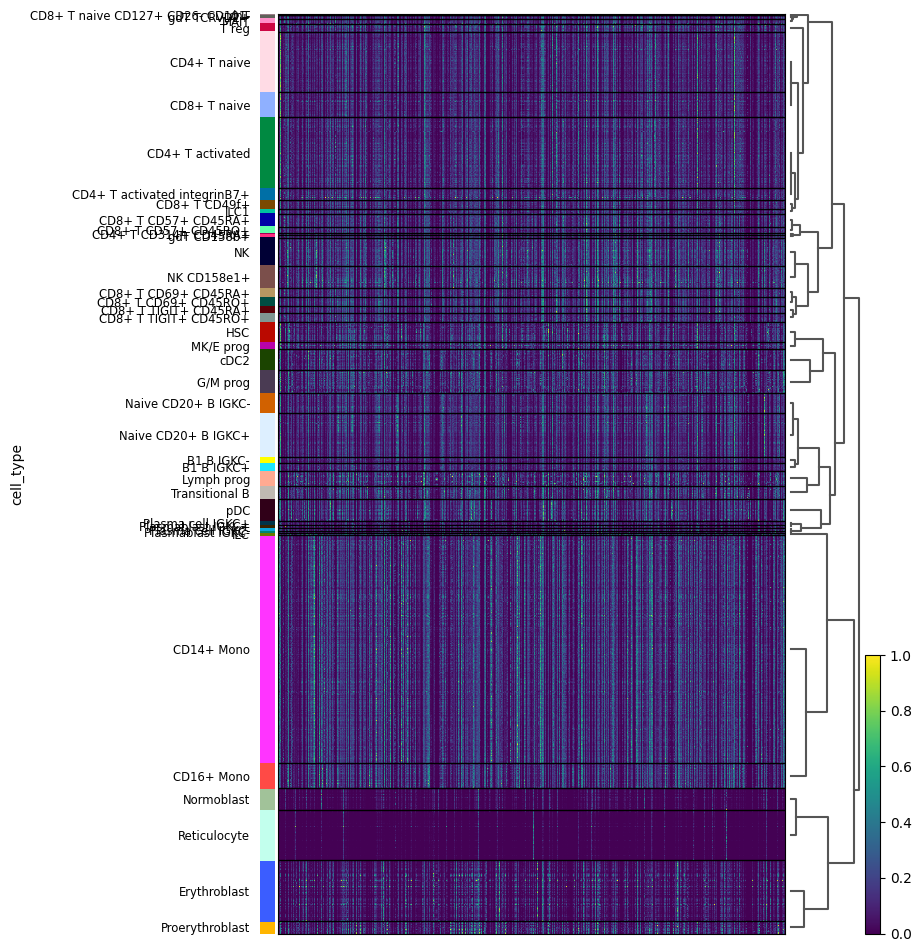

In [25]:
scanpy.pl.heatmap(
    X_train,
    var_names= X_train.var.index,
    groupby="cell_type",
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12),
)

## Magic imputaiton

In [3]:
magicus = magic.MAGIC(n_jobs=4,solver='exact',random_state=222)

In [4]:
magicus_test = magic.MAGIC(n_jobs=4,solver='exact',random_state=222)

In [5]:
magicus.fit(X_train)

MAGIC(knn_max=15, n_jobs=4, random_state=222)

In [6]:
magicus_test.fit(X_test)

MAGIC(knn_max=15, n_jobs=4, random_state=222)

In [7]:
imputed_data = magicus.transform(X_train.X)

In [8]:
imputed_test = magicus_test.transform(X_test.X)

In [9]:
imputed_data.write('/mnt/scratch/grunew14/data/X_train_impute.h5ad')

In [10]:
imputed_test.write('/mnt/scratch/grunew14/data/X_test_impute.h5ad')

In [26]:
# Perform PCA on the imputed data
scanpy.pp.pca(imputed_data)

# Calculate the nearest neighbors
scanpy.pp.neighbors(imputed_data)

# Compute the UMAP coordinates
scanpy.tl.umap(imputed_data)

/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


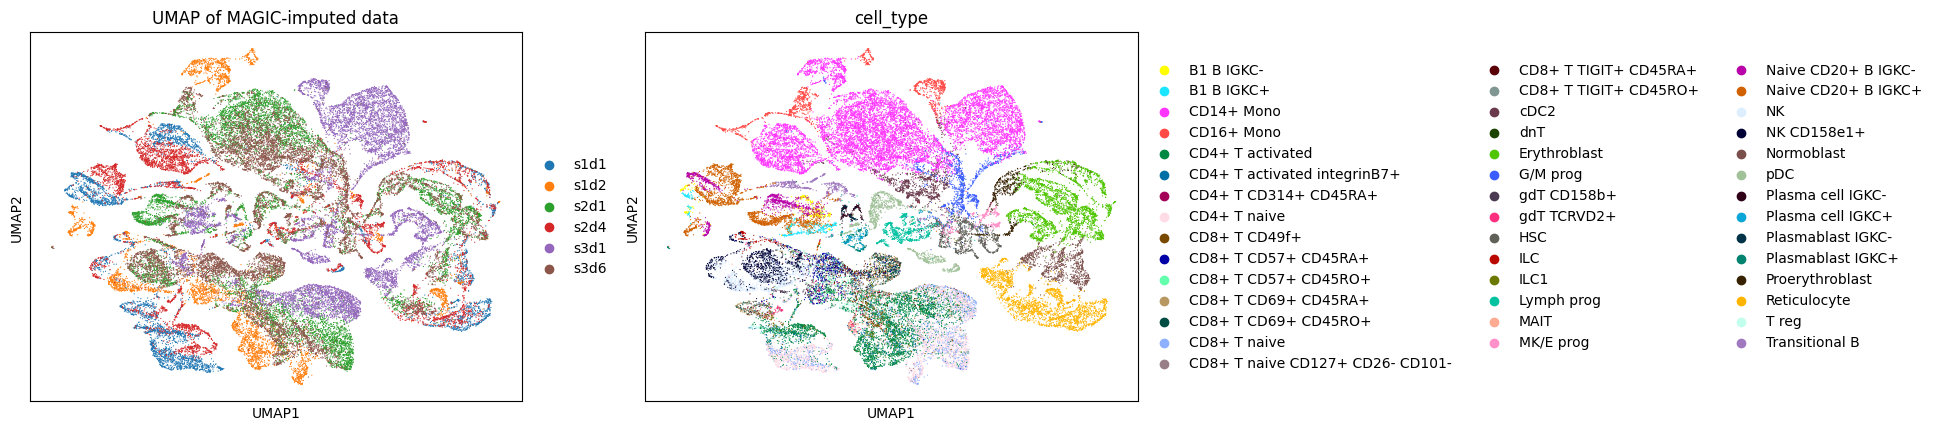

In [28]:
scanpy.pl.umap(imputed_data, color=['batch', 'cell_type'], title='UMAP of MAGIC-imputed data')

In [29]:
# Perform PCA on the imputed data
scanpy.pp.pca(imputed_test)

# Calculate the nearest neighbors
scanpy.pp.neighbors(imputed_test)

# Compute the UMAP coordinates
scanpy.tl.umap(imputed_test)

/mnt/home/grunew14/anaconda3/envs/dance-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


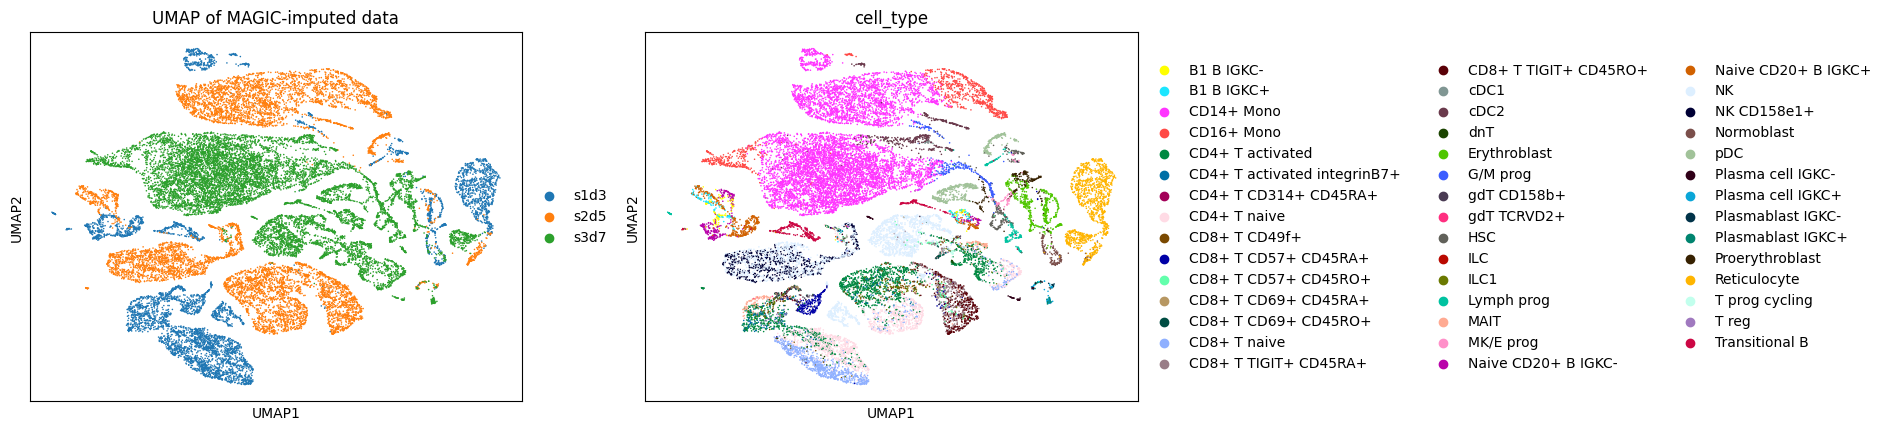

In [30]:
scanpy.pl.umap(imputed_test, color=['batch', 'cell_type'], title='UMAP of MAGIC-imputed data')

## PCA

In [16]:
pca = PCA()

In [19]:
X_train.X[:20000,:].shape

(20000, 13953)

In [20]:
pca.fit(X_train.X[:2000,:])

PCA()

## model time

In [17]:
X_train = ad.read_h5ad('../data/X_train_impute.h5ad')
X_test = ad.read_h5ad('../data/X_test_impute.h5ad')
y_train = ad.read_h5ad("../data/Adt_processed_training.h5ad")
y_test = ad.read_h5ad('../data/Adt_processed_testing.h5ad')

In [ ]:
from sklearn.preprocessing import StandardScaler

In [26]:
args = argparse.Namespace()
args.naive = True
args.hidden = 128*2
args.rnd_seed = random.randint(0, 2147483647)
args.device = 'cuda'
args.outdir = '/mnt/home/grunew14/Documents/ss-23-classes/cmse381/gene-project/model_results/'
args.batchsize = 50
args.lr = 0.001
args.lossweight = 0.03
args.earlystop = 20

In [4]:
X_train_nn = Tensor(X_train.X)
y_train_nn = Tensor(y_train.X.toarray())
X_test_nn =  Tensor(X_test.X)
y_test_nn =  Tensor(y_test.X.toarray())

In [27]:
babel_wrapper = BabelWrapper(args, dim_in =imputed_data.X.shape[1], dim_out = y_train.X.toarray().shape[1])

[INFO][2023-04-24 23:43:19,086][dance][__init__] ChromDecoder with 1 output activations
[INFO][2023-04-24 23:43:19,091][dance][__init__] ChromDecoder with 1 output activations


In [28]:
babel_wrapper.fit(X_train_nn, y_train_nn)

epoch:  1
training (sum of 4 losses): 0.20750830924161806
validation (prediction loss): 0.35465403733118417
epoch:  2
training (sum of 4 losses): 0.14549806270348312
validation (prediction loss): 0.3395108745275426
epoch:  3
training (sum of 4 losses): 0.13502233088889382
validation (prediction loss): 0.33737622838343506
epoch:  4
training (sum of 4 losses): 0.1315955139665424
validation (prediction loss): 0.3369141337181224
epoch:  5
training (sum of 4 losses): 0.12927808461910845
validation (prediction loss): 0.3325351996020021
epoch:  6
training (sum of 4 losses): 0.1273324960840131
validation (prediction loss): 0.33201794520370775
epoch:  7
training (sum of 4 losses): 0.12617137029538428
validation (prediction loss): 0.32722602351920066
epoch:  8
training (sum of 4 losses): 0.12520272987199793
validation (prediction loss): 0.3291958026635099
epoch:  9
training (sum of 4 losses): 0.12408590886217115
validation (prediction loss): 0.32733090542007215
epoch:  10
training (sum of 4 loss

In [29]:
babel_wrapper.score(X_test_nn, y_test_nn)

0.37406582504999963

## Tourch Models

In [5]:
train_dataset = TensorDataset(X_train_nn, y_train_nn)
test_dataset = TensorDataset(X_test_nn, y_test_nn)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [7]:
X_train_nn.shape[1]

13953

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X_train_nn.shape[1], 20000)
        self.bn1 = nn.BatchNorm1d(20000)
        self.fc2 = nn.Linear(20000, 15000)
        self.bn2 = nn.BatchNorm1d(15000)
        self.fc3 = nn.Linear(15000, 10000)
        self.bn3 = nn.BatchNorm1d(10000)
        self.fc4 = nn.Linear(10000, y_train_nn.shape[1])
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        
        return x


net = Net()

In [9]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [13]:
torch.cuda.empty_cache()

In [11]:
device = "cuda:0"
net = net.to(device)
X_train_nn = X_train_nn.to(device)
y_train_nn = y_train_nn.to(device)

epochs = 10
for epoch in range(epochs):
    # forward pass: compute predicted outputs by passing inputs to the model
    outputs = net(X_train_nn)
    # calculate the loss
    loss = criterion(outputs, y_train_nn)
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    
    # print training statistics
    print(f'Epoch: {epoch+1}/{epochs} \tLoss: {loss.item():.6f}')

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.14 GiB (GPU 0; 6.00 GiB total capacity; 4.93 GiB already allocated; 46.00 MiB free; 4.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [14]:
!nvidia-smi

Tue Apr 25 10:25:01 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060       WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8               10W /  N/A|   5154MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--